# The distribution of track listening

In [22]:
import numpy as np
import pandas as pd
import featuretools as ft
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
log_df = pd.read_csv('../data/raw/data/training_set/log_mini.csv')

In [181]:
print(len(log_df['track_id_clean'].unique()), 'unique tracks were played.')

50704 unique tracks were played.


In [182]:
# the tracks with the highest number of play
log_df['track_id_clean'].value_counts()[0:10]

t_bacf06d3-9185-4183-84ea-ff0db51475ce    1427
t_5718ab08-3a15-4d3f-9e63-42b2f6805e31     915
t_8c4d29b1-e0bf-464c-88f7-ac19240cbba0     785
t_a66ea088-b357-449a-8a1e-64dd0b8d6cb5     730
t_77b02acb-1b1f-4b36-b8fc-2c3e01892b9a     719
t_9a31436c-a57a-4d7a-9bbc-50f0deca33de     612
t_0e3dec82-10b4-49f1-8c2e-cd19249f7d2c     600
t_2fd6279a-06cd-4d5d-9e54-1912f51bb3c3     593
t_7533e7ff-568e-448b-904e-fc0c3a9ec87e     576
t_29a3895e-2c91-49a6-9383-6a71c597390d     548
Name: track_id_clean, dtype: int64

In [183]:
play1 = (log_df['track_id_clean'].value_counts()==1).sum()/len(log_df['track_id_clean'].unique())*100
play5 = (log_df['track_id_clean'].value_counts()<=5).sum()/len(log_df['track_id_clean'].unique())*100
play10 = (log_df['track_id_clean'].value_counts()<=10).sum()/len(log_df['track_id_clean'].unique())*100

print('% of tracks only been played 1 time:',play1)
print('% of tracks only been played 5 times of less:',play5)
print('% of tracks only been played 10 times of less:',play10)

% of tracks only been played 1 time: 62.7623067213632
% of tracks only been played 5 times of less: 91.48193436415272
% of tracks only been played 10 times of less: 96.14034395708426


# Try clustering the tracks by their acoustic features

The idea of Collaborative Filtering is to look at the data of other similar sessions, as similar sessions should have similar skipping behavior.
However, as 91.5% of the tracks has only been played 5 times of less, the similar tracks have to be grouped into clusters to increase the likelyhood of overlapped groups of tracks across sessions.

In [17]:
tf_df = pd.read_csv('../data/raw/data/track_features/tf_mini.csv')
tf_df_dummy = pd.get_dummies(tf_df, columns=['key','time_signature','mode'])


In [19]:
from sklearn.preprocessing import StandardScaler

# only pick these columns to do the clustering
sel_col_names = ['acousticness','beat_strength','danceability',
                        'dyn_range_mean', 'energy', 'flatness','instrumentalness', 'liveness', 
                        'loudness', 'mechanism', 'organism','speechiness','valence',
                        'acoustic_vector_0','acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
                        'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6','acoustic_vector_7']
x_cols = tf_df_dummy[sel_col_names]

# rescale the data
scaler = StandardScaler()
x_cols_scaled = scaler.fit_transform(x_cols)


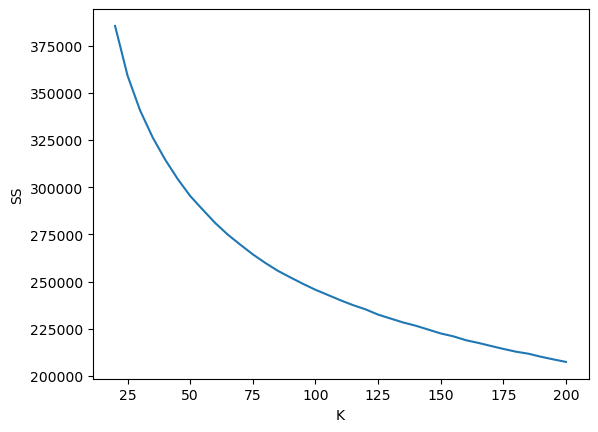

In [24]:
# explore the optimal k

from sklearn.cluster import KMeans
inertia = []
nClusters = []

for k in range(20,205,5):
    model = KMeans(n_clusters = k)
    model.fit(x_cols_scaled)
    inertia.append(model.inertia_)
    nClusters.append(k)
    
plt.plot(nClusters,inertia)
plt.xlabel('K')
plt.ylabel('SS')
plt.show()

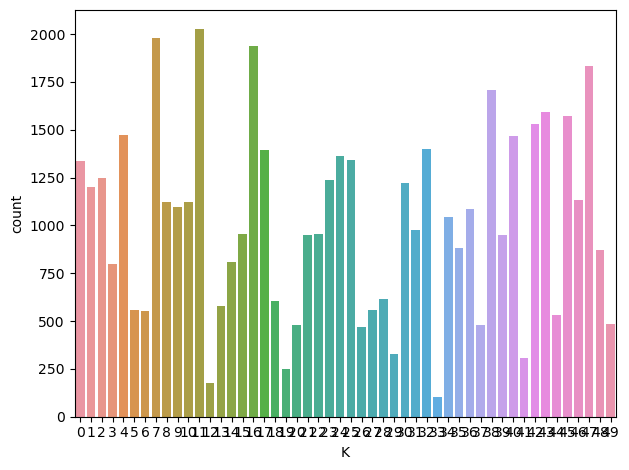

In [186]:
# k = 50 looks ok
km_model = KMeans(n_clusters = 50, random_state=23)
km_model.fit(x_cols_scaled)
clus = pd.DataFrame(km_model.predict(x_cols_scaled))
clus_count = pd.DataFrame(clus.value_counts(), columns = ['count']).reset_index()
clus_count
ax = sns.barplot(x = clus_count.iloc[:,0], y = clus_count['count'])
ax.set(xlabel='K', ylabel='count')
plt.tight_layout()
plt.show()

In [61]:
# put the cluster label into the track dataframe
tf_df_dummy['clus'] = clus

In [62]:
# perform a simple dataframe join
df = log_df.merge(tf_df_dummy, left_on = 'track_id_clean', right_on = 'track_id')
df.sort_values(by = ['session_id', 'session_position'],inplace = True)
df.head().T

,0,45,50,327,353
session_id,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e
session_position,1,2,3,4,5
session_length,20,20,20,20,20
track_id_clean,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,t_64f3743c-f624-46bb-a579-0f3f9a07a123
skip_1,False,False,False,False,False
...,...,...,...,...,...
time_signature_4,1,1,1,1,1
time_signature_5,0,0,0,0,0
mode_major,1,0,1,1,1
mode_minor,0,1,0,0,0


## Recommendation Filtering

https://towardsdatascience.com/recommender-systems-item-customer-collaborative-filtering-ff0c8f41ae8a
https://github.com/DAR-DatenanalyseRehberg/RecommenderBinaryCF/blob/main/RecommenderCollaborativeFilteringDDDD.ipynb

In [63]:
sessions = list(np.sort(df['session_id'].unique())) 
tracks = list(df['clus'].unique()) 
no_skip_1 = list(df['skip_1']==False) 

In [64]:
DfSessionUnique = []
DfSessionUnique = pd.DataFrame(sessions,columns=['sessions'])
DfSessionUnique.head()

,sessions
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130


In [65]:
from scipy import sparse
from pandas.api.types import CategoricalDtype

rows = df['session_id'].astype(CategoricalDtype(categories=sessions)).cat.codes # We have got 36 unique customers, which make up 13837 data rows (index)

# Get the associated row indices
cols = df['clus'].astype(CategoricalDtype(categories=tracks)).cat.codes # We have got unique 3725 SalesItems, making up 13837 data rows (index)


In [66]:
# Get the associated column indices
#Compressed Sparse Row matrix
listeningSparse = []
listeningSparse = sparse.csr_matrix((no_skip_1*1, (rows, cols)), shape=(len(sessions), len(tracks))) #len of customers=35, len of products=3725
#csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
#where data, row_ind and col_ind satisfy the relationship a[row_ind[k], col_ind[k]] = data[k]. , see https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

listeningSparse
#a sparse matrix is not a pandas dataframe, but sparse matrices are efficient for row slicing and fast matrix vector products

<10000x50 sparse matrix of type '<class 'numpy.bool_'>'
	with 73946 stored elements in Compressed Sparse Row format>

In [67]:
#We have 35 customers with 3725 items. For these user/item interactions, 13837 of these items had a purchase. 
#In terms of sparsity of the matrix, that makes:
MatrixSize = listeningSparse.shape[0]*listeningSparse.shape[1] # 130375 possible interactions in the matrix (35 unique customers * 3725 unique SalesItems=130375)
listeningAmount = len(listeningSparse.nonzero()[0]) # 13837 SalesItems interacted with; 
sparsity = 100*(1 - (listeningAmount/MatrixSize))
sparsity

89.4668

## Recommending

In [70]:
#for every dataset we will add a 1 as purchased. That means, that this customer has purchased this item, no matter how many. We use this binary data for our recommending. Another approach would be to use the SalesAmount and 
#normalize it, in case you want to treat the Amount of SalesItems purchased as a kind of taste factor, meaning that someone who bought SalesItem x 100 times, while another Customer bought that same SalesItem x only 5 times does 
#not like it as much. I believe, that very often in Sales a binary approach makes more sense, but of course that depends on the data.
def create_DataBinary(df):
  # DataPrep must be DataGrouped?!
    DataBinary = df.copy()
    DataBinary['ListenYes'] = 1 
    return DataBinary

DataBinary = create_DataBinary(df)
DataBinary.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,key_11,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5,mode_major,mode_minor,clus,ListenYes
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,0,0,0,0,1,0,1,0,43,1
45,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,...,0,0,0,0,1,0,0,1,21,1
50,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,...,0,0,0,0,1,0,1,0,27,1
327,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,...,0,0,0,0,1,0,1,0,39,1
353,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,...,0,0,0,0,1,0,1,0,44,1


In [153]:
data2=DataBinary[['session_id','clus','ListenYes']]
data2.head(20)

,session_id,clus,ListenYes
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,43,1
45,0_00006f66-33e5-4de7-a324-2d18e439fc1e,21,1
50,0_00006f66-33e5-4de7-a324-2d18e439fc1e,27,1
327,0_00006f66-33e5-4de7-a324-2d18e439fc1e,39,1
353,0_00006f66-33e5-4de7-a324-2d18e439fc1e,44,1
475,0_00006f66-33e5-4de7-a324-2d18e439fc1e,32,1
537,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0,1
540,0_00006f66-33e5-4de7-a324-2d18e439fc1e,32,1
541,0_00006f66-33e5-4de7-a324-2d18e439fc1e,21,1
601,0_00006f66-33e5-4de7-a324-2d18e439fc1e,15,1


In [154]:
#for better convenience we add I for Item for every SalesItem. Otherwise we would only have customer and SalesItem Numbers, which can be a little bit puzzling.
data2['clus'] = 'c' + data2['clus'].astype(str)
data2

,session_id,clus,ListenYes
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c43,1
45,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c21,1
50,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c27,1
327,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c39,1
353,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c44,1
...,...,...,...
134522,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,c20,1
134516,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,c20,1
134510,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,c46,1
134504,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,c8,1


In [162]:
# data3 = data2.groupby(['session_id', 'clus']).sum()

data3 = data2.groupby(['session_id', 'clus']).agg({'ListenYes':['sum']})
data3 = data3.reset_index()
data3.columns = data3.columns.droplevel(level = 1)
data3

,session_id,clus,ListenYes
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c0,2
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c15,1
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c21,3
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c25,1
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c27,3
...,...,...,...
73941,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,c22,1
73942,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,c37,1
73943,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,c38,1
73944,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,c46,8


In [166]:
#DfMatrix = pd.pivot_table(data,index=["Customer"], columns='SalesItem')
# DfMatrix = pd.pivot_table(data2, values='ListenYes', index='session_id', columns='clus')
DfMatrix = pd.pivot_table(data3, values='ListenYes', index='session_id', columns='clus')

DfMatrix.head()

clus,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
session_id,,,,,,,,,,,,,,,,,,,,,
0_00006f66-33e5-4de7-a324-2d18e439fc1e,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0_0000a72b-09ac-412f-b452-9b9e79bded8f,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
0_00016a3d-9076-4f67-918f-f29e3ce160dc,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0
0_00018b58-deb8-4f98-ac5e-d7e01b346130,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,3.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [167]:
#since we are only using 1 and 0, we do not need to think about normalization. But talk is cheap, let`s check to see that even if we would normalize, the result is the same, of course:
DfMatrix=DfMatrix.fillna(0) #NaN values need to get replaced by 0, meaning they have not been purchased yet.
DfMatrix

clus,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
session_id,,,,,,,,,,,,,,,,,,,,,
0_00006f66-33e5-4de7-a324-2d18e439fc1e,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
0_00018b58-deb8-4f98-ac5e-d7e01b346130,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0_0eac164c-f209-4590-8608-a56e67658952,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
0_0eacbee7-9868-48a0-9ab0-f86069329f50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
0_0ead11fc-f32c-4eb4-8fc1-15b51432a404,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [168]:
DfMatrixNorm3 = (DfMatrix-DfMatrix.min())/(DfMatrix.max()-DfMatrix.min())
DfMatrixNorm3.head()
#the proof is in the pudding. But we will come back to normalization later on again, when we will take real Sales Amount into consideration for recommending as well.

clus,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
session_id,,,,,,,,,,,,,,,,,,,,,
0_00006f66-33e5-4de7-a324-2d18e439fc1e,0.1250,0.000000,0.0,0.0,0.0,0.000000,0.000,0.071429,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00
0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.125,0.000000,0.0,0.000000,...,0.000000,0.055556,0.0,0.000000,0.166667,0.0,0.133333,0.0,0.000000,0.00
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,0.0625,0.000000,0.0,0.0,0.0,0.000000,0.000,0.071429,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.263158,0.00
0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.0000,0.083333,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.200000,...,0.000000,0.166667,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.65
0_00018b58-deb8-4f98-ac5e-d7e01b346130,0.0000,0.000000,0.0,0.0,0.0,0.083333,0.000,0.000000,0.0,0.066667,...,0.176471,0.166667,0.0,0.058824,0.000000,0.0,0.000000,0.0,0.000000,0.00


In [169]:
#we need to bring our pivot table into the desired format, via reset_index and rename_axis. 
DfResetted = DfMatrix.reset_index().rename_axis(None, axis=1) 
DfResetted.head()
#Now each row represents one customer`s buying behaviour: 1 means the customer has purchased, NaN the customer has not yet purchased it

,session_id,c0,c1,c10,c11,c12,c13,c14,c15,c16,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [170]:
DfMatrix.shape

(10000, 50)

In [171]:
DfTracksListen = DfResetted.drop(columns=['session_id'])
DfTracksListen.head()

,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [172]:
#Calculate the Item based recommendation
import numpy as np
# We will normalize dataframe now, due to ..
#I believe we do not need to normalize, but let us compare..
#vectorized
DfTracksListenNorm = DfTracksListen / np.sqrt(np.square(DfTracksListen).sum(axis=0)) 
DfTracksListenNorm.head()

,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
0,0.020742,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00585,0.0,0.000000,...,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.000000,0.0,0.000000,0.000000
1,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.022625,0.00000,0.0,0.000000,...,0.000000,0.008808,0.0,0.00000,0.03568,0.0,0.018259,0.0,0.000000,0.000000
2,0.010371,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00585,0.0,0.000000,...,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.000000,0.0,0.026865,0.000000
3,0.000000,0.011825,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.021553,...,0.000000,0.026424,0.0,0.00000,0.00000,0.0,0.000000,0.0,0.000000,0.077072
4,0.000000,0.000000,0.0,0.0,0.0,0.012017,0.000000,0.00000,0.0,0.007184,...,0.015988,0.026424,0.0,0.01041,0.00000,0.0,0.000000,0.0,0.000000,0.000000


In [173]:
# Calculating with Vectors to compute Cosine Similarities
TrackTrackSim = DfTracksListenNorm.transpose().dot(DfTracksListenNorm) 
TrackTrackSim.head()

,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
c0,1.000000,0.035199,0.002130,0.073540,0.036525,0.031033,0.051975,0.266602,0.046195,0.030474,...,0.131710,0.058372,0.009930,0.129879,0.026643,0.007308,0.015244,0.011289,0.264301,0.014142
c1,0.035199,1.000000,0.004555,0.146706,0.061034,0.104162,0.395310,0.020685,0.057635,0.177984,...,0.082242,0.154986,0.134320,0.047886,0.043670,0.017980,0.212141,0.007614,0.047781,0.100325
c10,0.002130,0.004555,1.000000,0.003722,0.000000,0.007097,0.003050,0.002253,0.000967,0.010146,...,0.004037,0.002827,0.008940,0.003608,0.013742,0.000159,0.009142,0.004133,0.007450,0.002968
c11,0.073540,0.146706,0.003722,1.000000,0.031540,0.212806,0.227529,0.043109,0.056665,0.116637,...,0.094955,0.084586,0.044948,0.230373,0.038791,0.008512,0.116348,0.024259,0.057571,0.068393
c12,0.036525,0.061034,0.000000,0.031540,1.000000,0.025539,0.033659,0.033984,0.102566,0.017595,...,0.041744,0.082006,0.029068,0.028023,0.010833,0.005755,0.021435,0.022651,0.044805,0.007920


In [174]:
#Another approach to the above would be using corr fct
#Where is the difference?
TrackTrackCorr = DfTracksListenNorm.corr()
TrackTrackCorr.head()

,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
c0,1.000000,-0.076173,-0.023326,-0.032899,-0.025642,-0.063003,-0.062541,0.085138,-0.060753,-0.106962,...,-0.052564,-0.087249,-0.043216,0.004214,-0.036168,-0.055579,-0.078271,-0.020595,0.047883,-0.092974
c1,-0.076173,1.000000,-0.011021,0.086024,0.023435,0.050548,0.350297,-0.128911,-0.007590,0.106689,...,-0.035609,0.075274,0.106873,-0.036783,0.005484,-0.020241,0.166297,-0.012310,-0.126035,0.040230
c10,-0.023326,-0.011021,1.000000,-0.011883,-0.008955,-0.005982,-0.013316,-0.031399,-0.014321,-0.008586,...,-0.024352,-0.018023,0.001672,-0.015897,0.005018,-0.008483,-0.003568,-0.000322,-0.032148,-0.011723
c11,-0.032899,0.086024,-0.011883,1.000000,-0.007436,0.165797,0.170010,-0.102121,-0.008623,0.039904,...,-0.020957,-0.002066,0.013665,0.162333,0.000379,-0.030143,0.064803,0.004967,-0.113664,0.006165
c12,-0.025642,0.023435,-0.008955,-0.007436,1.000000,-0.007623,-0.007024,-0.047715,0.067805,-0.030818,...,-0.027151,0.034010,0.010734,-0.020762,-0.011800,-0.016329,-0.011067,0.011478,-0.050722,-0.029745


In [175]:
#ItemItemSim.to_excel("ExportItem-Item.xlsx")
# Create a placeholder items for closes neighbours to an item
TrackNeighbours = pd.DataFrame(index=TrackTrackSim.columns,columns=range(1,51))
TrackNeighbours.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
c0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
# Create a placeholder items for closes neighbours to an item
#ItemNeighbours = pd.DataFrame(index=ItemItemSim.columns,columns=range(1,10)) 
# Loop through our similarity dataframe and fill in neighbouring item names
for i in range(0,len(TrackTrackSim.columns)):
    TrackNeighbours.iloc[i,:50] = TrackTrackSim.iloc[0:,i].sort_values(ascending=False)[:50].index
    #we only have 9 items, so we can max recommend 9 items (itself included)

TrackNeighbours

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
c0,c0,c39,c32,c21,c42,c27,c23,c15,c8,c3,...,c29,c18,c7,c47,c19,c5,c40,c2,c10,c30
c1,c1,c14,c6,c18,c17,c22,c35,c46,c11,c47,...,c40,c33,c41,c26,c19,c29,c7,c2,c10,c30
c10,c10,c26,c36,c27,c28,c34,c49,c42,c17,c22,...,c16,c33,c24,c37,c40,c29,c5,c19,c38,c12
c11,c11,c22,c48,c14,c13,c24,c1,c39,c17,c6,...,c42,c25,c7,c29,c41,c5,c10,c19,c2,c30
c12,c12,c33,c37,c31,c16,c38,c4,c46,c39,c44,...,c49,c34,c9,c29,c26,c5,c19,c30,c2,c10
c13,c13,c6,c20,c34,c11,c49,c22,c36,c38,c14,...,c7,c35,c5,c29,c31,c2,c10,c41,c19,c30
c14,c14,c1,c11,c22,c18,c6,c47,c17,c35,c4,...,c33,c29,c7,c40,c41,c5,c2,c19,c10,c30
c15,c15,c21,c44,c8,c32,c27,c25,c0,c39,c3,...,c5,c2,c38,c19,c34,c40,c7,c29,c10,c30
c16,c16,c31,c37,c45,c3,c48,c46,c39,c27,c17,...,c49,c40,c7,c29,c5,c26,c19,c2,c10,c30
c17,c17,c9,c24,c22,c46,c45,c1,c14,c48,c35,...,c26,c10,c33,c40,c5,c7,c19,c2,c29,c30


In [177]:
#Now we will build a Customer based recommendation, which is build upon the item-item similarity matrix, which we have just calculated above.
# Create a place holder matrix for similarities, and fill in the customer column
SessTrackSimilarity = pd.DataFrame(index=DfResetted.index, columns=DfResetted.columns)
SessTrackSimilarity.iloc[:,:1] = DfResetted.iloc[:,:1]
SessTrackSimilarity.head()

,session_id,c0,c1,c10,c11,c12,c13,c14,c15,c16,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
# Getting the similarity scores
def getScore(history, similarities):
    return sum(history*similarities)/sum(similarities) 

In [179]:
# This takes ages (35 customers * 3725 items)
#We now loop through the rows and columns filling in empty spaces with similarity scores.
#Note that we score items that the customer has already consumed as 0, because there is no point recommending it again.
from timeit import default_timer as timer #to see how long the computation will take
start = timer()
SessionListening = []
TrackTopSimilarity = []

for i in range(0,len(SessTrackSimilarity.index)):
    for j in range(1,len(SessTrackSimilarity.columns)):
# for i in range(0,1):
#     for j in range(1,2):
        ses = SessTrackSimilarity.index[i]
        tra = SessTrackSimilarity.columns[j]
        
        SessionListening = DfTracksListen.loc[ses,]
        TrackSimilarity = TrackTrackSim[tra]
        SessTrackSimilarity.loc[i][j] = sum(SessionListening*TrackSimilarity)/sum(TrackSimilarity)
#         SessTrackSimilarity.loc[i][j] = getScore(SessionListening,TrackTopSimilarity)
        
        
        
#         if DfResetted.loc[i][j] == 1:
#             SessTrackSimilarity.loc[i][j] = 0
#         else:
#             TrackTop = TrackNeighbours.loc[tra][1:9] #
#             TrackTopSimilarity = TrackTrackSim.loc[tra].sort_values(ascending=False)[1:9]
#             print(TrackTopSimilarity)
#     #         #here we will use the item dataframe, which we generated during item-item matrix 
#             SessionListening = DfTracksListen.loc[ses,TrackTop]
#     #         SessionListening = DfTracksListen.loc[ses,]
#             print(SessionListening)
 
#             SessTrackSimilarity.loc[i][j] = getScore(SessionListening,TrackTopSimilarity)

end = timer()

print('\nRuntime: %0.2fs' % (end - start))

#if there occurs a strange error  tz=getattr(series.dtype, 'tz', None) .. pandas index.. then this might be if you have used int
# as column headers instead of string


Runtime: 118.91s


In [180]:
SessTrackSimilarity

,session_id,c0,c1,c10,c11,c12,c13,c14,c15,c16,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1.283031,0.164149,0.087817,0.250674,0.294955,0.111329,0.213508,1.345156,0.396782,...,0.556471,0.347841,0.081454,0.425144,0.160866,0.097524,0.078455,0.065803,1.121535,0.123588
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.07716,0.602176,0.186519,0.373492,0.126728,0.827433,0.758365,0.054876,0.162681,...,0.185626,0.404973,0.551847,0.21472,1.133816,0.177057,1.19852,0.063191,0.089936,0.390775
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,1.063347,0.172037,0.11623,0.227932,0.268716,0.114196,0.214468,1.383014,0.339027,...,0.557881,0.385764,0.089722,0.367676,0.162088,0.128957,0.085332,0.062803,1.578177,0.137161
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.089531,0.714184,0.061372,0.359091,0.142098,0.443858,0.434537,0.079504,0.239077,...,0.437454,1.198499,0.199282,0.439893,0.212528,0.078222,0.445314,0.038109,0.145049,4.242847
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130,0.205307,0.272021,0.041586,0.318235,0.159532,0.360876,0.245095,0.126666,0.350356,...,0.848172,0.95581,0.090778,0.589371,0.156038,0.095144,0.207225,0.040878,0.206904,0.449341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0_0eac164c-f209-4590-8608-a56e67658952,0.659489,0.24944,0.080207,0.265047,0.684981,0.207999,0.270539,1.039767,0.905976,...,0.669993,0.455876,0.178697,0.406217,0.202592,0.096681,0.174612,0.08853,0.997335,0.172278
9996,0_0eacbee7-9868-48a0-9ab0-f86069329f50,0.994909,0.149698,0.078045,0.214429,0.262215,0.108784,0.195918,1.948765,0.318541,...,0.47964,0.343446,0.083187,0.361491,0.138667,0.078296,0.074879,0.058832,1.479077,0.130331
9997,0_0ead11fc-f32c-4eb4-8fc1-15b51432a404,1.059899,0.17598,0.106908,0.250801,0.311404,0.1325,0.229009,1.577094,0.322596,...,0.513759,0.393523,0.092718,0.385023,0.16506,0.085143,0.095262,0.06516,1.311584,0.138544
9998,0_0eae096d-ae4c-4556-8227-0f6294958330,0.058255,0.351161,0.069548,0.425228,0.076291,1.604112,0.331906,0.039017,0.062862,...,0.084649,0.204131,0.185732,0.155551,0.581329,0.06374,1.379175,0.057416,0.052281,0.956707
